In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=120)

,time,ind_fact,ind_x,seg_fact_0,seg_x_0,seg_fact_1,seg_x_1,sub_fact_0,sub_x_0,sub_fact_1,...,y_1_0,y_1_1,y_1_2,y_1_3,y_1_4,y_1_5,y_1_6,y_1_7,y_1_8,y_1_9
0,2006-01-01,0.617965,0.654700,0.517785,0.200695,-0.999200,0.259699,-0.601661,0.320737,-2.880944,...,-0.903416,-3.624480,-0.676901,0.225051,-0.402669,0.996442,-0.301102,-0.541401,-0.653735,-1.028007
1,2006-02-01,0.834329,0.525347,-0.303949,-0.666398,-1.807114,-1.107674,1.130150,1.370814,-1.332009,...,1.059483,-2.147950,-1.861715,-1.222262,-1.503673,-0.586630,-2.058068,-2.576342,-1.660139,0.944859
2,2006-03-01,-0.619074,-1.036238,-1.258184,-1.045420,0.595070,1.860050,0.943967,0.491907,1.535079,...,0.871972,1.476936,0.503203,0.789826,0.476893,-0.093613,-1.261803,0.218134,0.351041,0.191503
3,2006-04-01,-0.951931,-0.642394,-1.439187,-0.558457,1.510847,1.094298,-1.245657,-1.623244,0.555072,...,-0.086988,1.140405,1.892746,0.990416,-2.773743,2.169177,1.810405,1.177781,0.084788,0.820196
4,2006-05-01,-0.622445,-0.146479,0.117217,1.124647,0.432032,-0.625561,-1.299055,-0.800792,0.722353,...,-1.331668,-0.175993,-0.587980,-0.197530,-0.570928,2.045843,0.069111,0.787934,1.722082,-0.758524


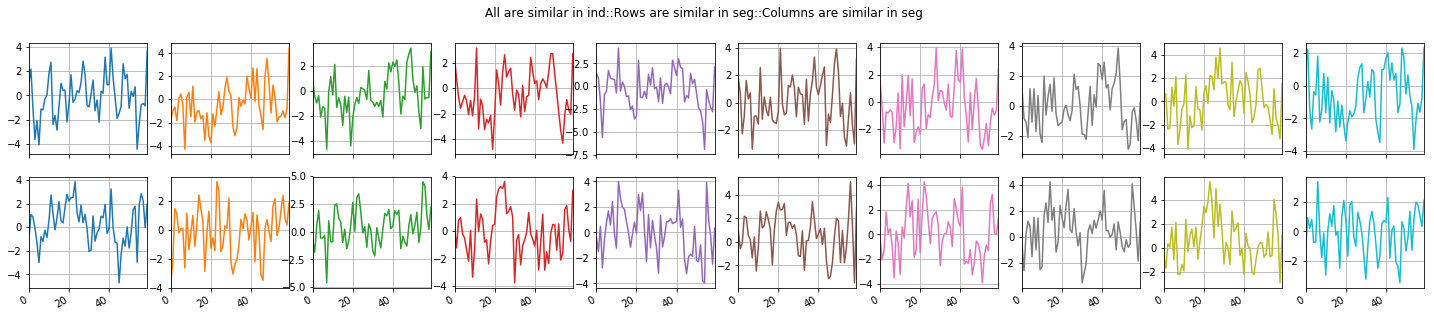

In [3]:
###simulate time series data 
periods=1000
seed=98165
# factor_model=pd.DataFrame(pd.date_range(start='1/1/2018', end='2/1/2019', freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

factor_model=pd.DataFrame(pd.date_range(start='1/1/2006', periods=periods, freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

np.random.seed(seed)

def factor_gen(size=periods, beta=0.8, burner=2, scale=1):
    j=burner+size
    x=np.random.normal(loc=0.0, scale=scale, size=j)
    
    y=[0]*j
    for i in range(j):
        
        if i==0:
            y0=0 
        else:
            y[i]=beta*y0 + x[i]
            y0=y[i]
            
    return y[-size:], x[-size:]

###industry factor
fact_name='ind_fact'
fact_name_x='ind_x'
fact, fact_x = factor_gen(size=periods, beta=0.5, burner=200)
factor_model[fact_name]=fact 
factor_model[fact_name_x]=fact_x 

###segment factor
seg=2
sub=10
for i in range(seg):
    fact_name='seg_fact_'+str(i)
    fact_name_x='seg_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.7, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 

###brand factor
for i in range(sub):
    fact_name='sub_fact_'+str(i)
    fact_name_x='sub_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.4, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 
    
###idiosyncratic factor
for s in range(seg):
    for b in range(sub):
        fact_name='idi_fact_' + str(s) + '_' + str(b)
        fact_name_x='idi_fact_x' + str(s) + '_' + str(b)
        fact, fact_x = factor_gen(size=periods, beta=0.0, burner=200, scale=0.5)
        factor_model[fact_name]=fact
        factor_model[fact_name_x]=fact_x

factor_model['x1']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
factor_model['x2']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))       
        
###observed y --output

for s in range(seg):
    for b in range(sub):
        fact_name='y_' + str(s) + '_' + str(b)
        seg_fact='seg_fact_' + str(s)
        sub_fact='sub_fact_' + str(b)
        idi_fact= 'idi_fact_' + str(s) + '_' + str(b)
        factor_model[fact_name]=factor_model['ind_fact']+factor_model[seg_fact] + factor_model[sub_fact] + factor_model[idi_fact]
#         factor_model[fact_name]=factor_model['ind_fact'] +factor_model[seg_fact] + factor_model[idi_fact] + 2*factor_model['x1'] -  2*factor_model['x2']
        factor_model[fact_name_x]=fact_x
    
# print(factor_model.columns)
_=factor_model[[name for name in factor_model.columns if 'y_' in name]][(
    factor_model.time.dt.year<=2010)].plot(subplots=True, layout=( seg,sub), figsize=(25, 5), grid=True, legend=False, 
                                           title='All are similar in ind::Rows are similar in seg::Columns are similar in seg')
factor_model.head(5)

In [4]:
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2']]

f_ind=1
f_seg=2
f_sub=10

k_factors=f_ind + f_seg + f_sub
fix_obs_cov=True

endog.columns
#######generate matrix below########
design = np.zeros((len(endog.columns), k_factors))

design[:,0]=1   #set the first column as ones for ind_factor
n=0
for char in endog.columns: #set the first column as ones for f_seg
    numl = [int(i) for i in char.split('_') if i.isdigit()]
    num=numl[0]
    design[n, num+1] = 1
    n+=1

n=0
for char in endog.columns: #set the first column as ones for f_seg
    numl = [int(i) for i in char.split('_') if i.isdigit()]
    num=numl[1]
    design[n, f_seg+num+1] = 1
    n+=1
    
design
print('initials: --paste to the following cell')    
print("self['transition'] = np.eye(", k_factors , ")") 
print("self['selection'] = np.eye(",  k_factors , ")") 
print("self['state_cov'] = np.eye(",  k_factors , ")") 
print("self['obs_cov'] = np.eye(", len(endog.columns) , ")")  

n=0
param_list=[]
update_list=[]
for i_c in range(k_factors):
    for j_r in range(len(endog.columns)):
        if design[j_r, i_c]==1.0:
            name='load_'+str(i_c)+'_'+str(j_r)
            param_list.append(name) 
            update_str = "self['design'" + ',' + str(j_r) + ',' + str(i_c) + "] = params[" +str(n) + "]"
            update_list.append(update_str)
            n+=1
           
for i in range(k_factors):
    name='f_ar_'+str(i)
    param_list.append(name) 
    update_str = "self['transition'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
    update_list.append(update_str)
    n+=1

if fix_obs_cov==False:
    for i in range(len(endog.columns)):
        name='err_var_'+str(i)
        param_list.append(name) 
        update_str = "self['obs_cov'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
        update_list.append(update_str)
        n+=1

update_statement=(';').join(update_list)       
# print();print();print()
# print('parameter names:')
# param_list
# print();print();print()
# print('updates: --paste to the following cell')
# update_list
# update_statement
# update_list

Index(['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7',
       'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5',
       'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9'],
      dtype='object')

array([[1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 

initials: --paste to the following cell
self['transition'] = np.eye( 13 )
self['selection'] = np.eye( 13 )
self['state_cov'] = np.eye( 13 )
self['obs_cov'] = np.eye( 20 )


In [5]:
# Construct the model

class Three_factor(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(Three_factor, self).__init__(endog,   k_states=13, factor_order=1, error_order=1,
                                  initialization='stationary')
#         k_factors=1, factor_order=1, error_order=1

        # Setup the fixed components of the state space representation
        self['design'] = design
        self['transition'] = np.eye( 13 )
        self['selection'] = np.eye( 13 )
        self['state_cov'] = np.eye( 13 )
        self['obs_cov'] = np.eye( 20 )*0.5*0.5



    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(Three_factor, self).update(params, transformed, **kwargs)
        exec(update_statement)
        
    @property
    def param_names(self):
        return param_list

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0.1]*73


# Create and fit the model

from numpy.linalg import LinAlgError
import time

for idx_s in [0, 600]:
    ts=time.time()
    idx_e=idx_s+150
    endog1=endog[idx_s:idx_e]
    print('---->', idx_s, '~~~', idx_e)
    mod = Three_factor(endog1)
    try:
        res = mod.fit( disp=True, maxiter=5000)
    except res.LinAlgError as e:
        continue
    print(res.summary())
    print(time.time()-ts)

----> 0 ~~~ 150
                                                                                                            Statespace Model Results                                                                                                            
Dep. Variable:     ['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7', 'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5', 'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9']   No. Observations:                  150
Model:                                                                                                                                                                                     Three_factor   Log Likelihood               -4267.923
Date:                                                                                                                                                                                  Sun, 24 Jan 2021   AIC                           8681.845
Time:               

AttributeError: 'MLEResults' object has no attribute 'LinAlgError'

In [7]:
for idx_s in [0]:
    idx_e=idx_s+1000
    endog1=endog[idx_s:idx_e]
    print('---->', idx_s, '~~~', idx_e)
    mod = Three_factor(endog1)
    try:
        res = mod.fit( disp=True, maxiter=5000)
    except res.LinAlgError as e:
        continue
    print(res.summary())
    print(time.time()-ts)

----> 0 ~~~ 1000
                                                                                                            Statespace Model Results                                                                                                            
Dep. Variable:     ['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7', 'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5', 'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9']   No. Observations:                 1000
Model:                                                                                                                                                                                     Three_factor   Log Likelihood              -28731.654
Date:                                                                                                                                                                                  Sun, 24 Jan 2021   AIC                          57609.308
Time:              

In [8]:
## estimate with obs_cov

In [9]:
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2']]

f_ind=1
f_seg=2
f_sub=10

k_factors=f_ind + f_seg + f_sub
fix_obs_cov=False

endog.columns
#######generate matrix below########
design = np.zeros((len(endog.columns), k_factors))

design[:,0]=1   #set the 0th column as ones for ind_factor
n=0
for char in endog.columns: #set the first column as ones for f_seg 
    numl = [int(i) for i in char.split('_') if i.isdigit()]
    num=numl[0]
    design[n, num+1] = 1
    n+=1

n=0
for char in endog.columns: #set the first column after off-set f_seg as ones for f_sub
    numl = [int(i) for i in char.split('_') if i.isdigit()]
    num=numl[1]
    design[n, f_seg+num+1] = 1
    n+=1
    
design
print('initials: --paste to the following cell')    
print("self['transition'] = np.eye(", k_factors , ")") 
print("self['selection'] = np.eye(",  k_factors , ")") 
print("self['state_cov'] = np.eye(",  k_factors , ")") 
print("self['obs_cov'] = np.eye(", len(endog.columns) , ")")  

n=0
param_list=[]
update_list=[]
for i_c in range(k_factors):
    for j_r in range(len(endog.columns)):
        if design[j_r, i_c]==1.0:
            name='load_'+str(i_c)+'_'+str(j_r)
            param_list.append(name) 
            update_str = "self['design'" + ',' + str(j_r) + ',' + str(i_c) + "] = params[" +str(n) + "]"
            update_list.append(update_str)
            n+=1
           
for i in range(k_factors):
    name='f_ar_'+str(i)
    param_list.append(name) 
    update_str = "self['transition'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
    update_list.append(update_str)
    n+=1

if fix_obs_cov==False:
    for i in range(len(endog.columns)):
        name='err_var_'+str(i)
        param_list.append(name) 
        update_str = "self['obs_cov'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
        update_list.append(update_str)
        n+=1

update_statement=(';').join(update_list)       
# print();print();print()
# print('parameter names:')
# param_list
# print();print();print()
# print('updates: --paste to the following cell')
# update_list
# update_statement
update_list

Index(['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7',
       'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5',
       'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9'],
      dtype='object')

array([[1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 

initials: --paste to the following cell
self['transition'] = np.eye( 13 )
self['selection'] = np.eye( 13 )
self['state_cov'] = np.eye( 13 )
self['obs_cov'] = np.eye( 20 )


["self['design',0,0] = params[0]",
 "self['design',1,0] = params[1]",
 "self['design',2,0] = params[2]",
 "self['design',3,0] = params[3]",
 "self['design',4,0] = params[4]",
 "self['design',5,0] = params[5]",
 "self['design',6,0] = params[6]",
 "self['design',7,0] = params[7]",
 "self['design',8,0] = params[8]",
 "self['design',9,0] = params[9]",
 "self['design',10,0] = params[10]",
 "self['design',11,0] = params[11]",
 "self['design',12,0] = params[12]",
 "self['design',13,0] = params[13]",
 "self['design',14,0] = params[14]",
 "self['design',15,0] = params[15]",
 "self['design',16,0] = params[16]",
 "self['design',17,0] = params[17]",
 "self['design',18,0] = params[18]",
 "self['design',19,0] = params[19]",
 "self['design',0,1] = params[20]",
 "self['design',1,1] = params[21]",
 "self['design',2,1] = params[22]",
 "self['design',3,1] = params[23]",
 "self['design',4,1] = params[24]",
 "self['design',5,1] = params[25]",
 "self['design',6,1] = params[26]",
 "self['design',7,1] = param

In [10]:
# Construct the model

class Three_factor(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(Three_factor, self).__init__(endog,   k_states=13, factor_order=1, error_order=1,
                                  initialization='stationary')
#         k_factors=1, factor_order=1, error_order=1

        # Setup the fixed components of the state space representation
        self['design'] = design
        self['transition'] = np.eye( 13 )
        self['selection'] = np.eye( 13 )
        self['state_cov'] = np.eye( 13 )
        self['obs_cov'] = np.eye( 20 )



    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(Three_factor, self).update(params, transformed, **kwargs)
        exec(update_statement)
        
    @property
    def param_names(self):
        return param_list

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0.1]*93


# Create and fit the model

from numpy.linalg import LinAlgError
import time

for idx_s in [0]:
    ts=time.time()
    idx_e=idx_s+1000
    endog1=endog[idx_s:idx_e]
    print('---->', idx_s, '~~~', idx_e)
    mod = Three_factor(endog1)
    try:
        res = mod.fit( disp=True, maxiter=5000)
    except res.LinAlgError as e:
        continue
    print(res.summary())
    print(time.time()-ts)

----> 0 ~~~ 1000
                                                                                                            Statespace Model Results                                                                                                            
Dep. Variable:     ['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7', 'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5', 'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9']   No. Observations:                 1000
Model:                                                                                                                                                                                     Three_factor   Log Likelihood              -28716.590
Date:                                                                                                                                                                                  Sun, 24 Jan 2021   AIC                          57619.179
Time:              